# Collaborative Filtering with spark fkljhjsdfls

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics, RegressionMetrics
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime
import itertools

import pandas as pd
import matplotlib.pyplot as plt

**Spark**
- Transformations vs Actions
- Distributed
- Huge datasets

## 0. Loading data: movielens data
***

In [2]:
ratings = spark.read.csv("../data/movielens/ratings.csv", header=True).cache()

## 1. EDA
***

In [3]:
ratings.head(5)

[Row(userId='1', movieId='1', rating='4.0', timestamp='964982703'),
 Row(userId='1', movieId='3', rating='4.0', timestamp='964981247'),
 Row(userId='1', movieId='6', rating='4.0', timestamp='964982224'),
 Row(userId='1', movieId='47', rating='5.0', timestamp='964983815'),
 Row(userId='1', movieId='50', rating='5.0', timestamp='964982931')]

In [4]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [5]:
print("Total amount of ratings: {}".format(ratings.count()))

Total amount of ratings: 100836


In [6]:
ratings.summary().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|          1000129365|
|    25%|             177.0|          1199.0|               3.0|       1.018535155E9|
|    50%|             325.0|          2991.0|               3.5|       1.186086516E9|
|    75%|             477.0|          8092.0|               4.0|       1.435993828E9|
|    max|                99|           99992|               5.0|           999873731|
+-------+------------------+----------------+---------

In [7]:
print("Amount of unique users: {}".format(ratings.select('userId').distinct().count()))

Amount of unique users: 610


In [8]:
print("Amount of unique movies: {}".format(ratings.select('movieId').distinct().count()))

Amount of unique movies: 9724


In [9]:
print("Sparsity: {:0.5f}".format(ratings.count() /
                                 (ratings.select('userId').distinct().count() *
                                  ratings.select('movieId').distinct().count())))

Sparsity: 0.01700


In [10]:
# Convert timestamp to a datetime value
ratings = ratings.withColumn('ts', F.from_unixtime('timestamp'))
ratings.show(10, truncate=False)

+------+-------+------+---------+-------------------+
|userId|movieId|rating|timestamp|ts                 |
+------+-------+------+---------+-------------------+
|1     |1      |4.0   |964982703|2000-07-30 20:45:03|
|1     |3      |4.0   |964981247|2000-07-30 20:20:47|
|1     |6      |4.0   |964982224|2000-07-30 20:37:04|
|1     |47     |5.0   |964983815|2000-07-30 21:03:35|
|1     |50     |5.0   |964982931|2000-07-30 20:48:51|
|1     |70     |3.0   |964982400|2000-07-30 20:40:00|
|1     |101    |5.0   |964980868|2000-07-30 20:14:28|
|1     |110    |4.0   |964982176|2000-07-30 20:36:16|
|1     |151    |5.0   |964984041|2000-07-30 21:07:21|
|1     |157    |5.0   |964984100|2000-07-30 21:08:20|
+------+-------+------+---------+-------------------+
only showing top 10 rows



In [11]:
max_ts = datetime.strptime(ratings.agg({"ts":"max"}).collect()[0][0],'%Y-%m-%d %H:%M:%S')
min_ts = datetime.strptime(ratings.agg({"ts":"min"}).collect()[0][0],'%Y-%m-%d %H:%M:%S')
print("Min datum: {}\nMax datum {}\nVerschil in jaren: {:0.1f}".format(min_ts, max_ts, (max_ts - min_ts).days / 365))

Min datum: 1996-03-29 19:36:55
Max datum 2018-09-24 16:27:30
Verschil in jaren: 22.5


### 1.1 Movie perspective

In [12]:
# Show top 20 of most rated movies
rating_cnt = ratings.groupby('movieId').count()
rating_cnt.orderBy('count', ascending=False).show(10, truncate=False)

+-------+-----+
|movieId|count|
+-------+-----+
|356    |329  |
|318    |317  |
|296    |307  |
|593    |279  |
|2571   |278  |
|260    |251  |
|480    |238  |
|110    |237  |
|589    |224  |
|527    |220  |
+-------+-----+
only showing top 10 rows



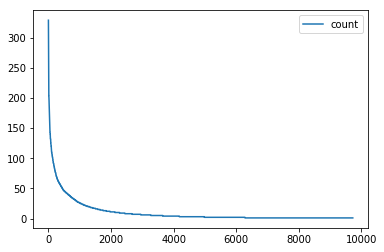

In [13]:
# Plot the counts per movie
rating_cnt.orderBy('count', ascending=False).toPandas().plot()

In [14]:
# Get counts per rating for each movie
rating_cnt_2 = ratings.groupby('movieId').pivot('rating').agg({"rating":"count"}).na.fill(0)
rating_cnt_2.show(10, truncate=False)

+-------+---+---+---+---+---+---+---+---+---+---+
|movieId|0.5|1.0|1.5|2.0|2.5|3.0|3.5|4.0|4.5|5.0|
+-------+---+---+---+---+---+---+---+---+---+---+
|2088   |0  |3  |1  |3  |2  |6  |1  |2  |0  |0  |
|112911 |1  |0  |1  |1  |0  |0  |0  |1  |0  |0  |
|3606   |0  |0  |0  |0  |0  |1  |2  |0  |0  |1  |
|4821   |1  |0  |0  |0  |1  |0  |1  |1  |0  |1  |
|5325   |0  |0  |0  |0  |0  |1  |2  |3  |1  |0  |
|102684 |0  |0  |0  |0  |0  |0  |1  |1  |0  |0  |
|3210   |1  |0  |1  |2  |1  |10 |6  |17 |3  |1  |
|691    |0  |0  |0  |0  |0  |2  |0  |1  |0  |0  |
|100553 |0  |0  |0  |0  |0  |0  |0  |0  |2  |0  |
|2294   |0  |0  |1  |4  |4  |16 |8  |9  |1  |2  |
+-------+---+---+---+---+---+---+---+---+---+---+
only showing top 10 rows



In [15]:
# Get total rating count per category

agg_functions = [
    F.sum(F.col('`0.5`')).alias('0.5'),
    F.sum('`1.0`').alias('1.0'),
    F.sum('`1.5`').alias('1.5'),
    F.sum('`2.0`').alias('2.0'),
    F.sum('`2.5`').alias('2.5'),
    F.sum('`3.0`').alias('3.0'),
    F.sum('`3.5`').alias('3.5'),
    F.sum('`4.0`').alias('4.0'),
    F.sum('`4.5`').alias('4.5'),
    F.sum('`5.0`').alias('5.0')
]

agg_ratings = rating_cnt_2.agg(*agg_functions)
agg_ratings.show()

+----+----+----+----+----+-----+-----+-----+----+-----+
| 0.5| 1.0| 1.5| 2.0| 2.5|  3.0|  3.5|  4.0| 4.5|  5.0|
+----+----+----+----+----+-----+-----+-----+----+-----+
|1370|2811|1791|7551|5550|20047|13136|26818|8551|13211|
+----+----+----+----+----+-----+-----+-----+----+-----+



In [16]:
agg_ratings.toPandas()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,1370,2811,1791,7551,5550,20047,13136,26818,8551,13211


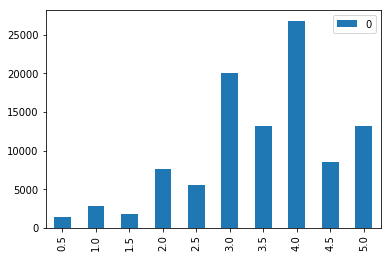

In [17]:
# Pandas is required to get nice graphs
agg_ratings.toPandas().T.plot.bar()

### 1.2 User perspective

In [18]:
# Count amount of ratings given per user
user_rating_cnt = ratings.groupby('userId').count()
user_rating_cnt.orderBy('count', ascending=False).show(10, truncate=False)

+------+-----+
|userId|count|
+------+-----+
|414   |2698 |
|599   |2478 |
|474   |2108 |
|448   |1864 |
|274   |1346 |
|610   |1302 |
|68    |1260 |
|380   |1218 |
|606   |1115 |
|288   |1055 |
+------+-----+
only showing top 10 rows



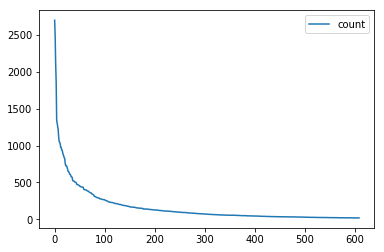

In [19]:
# Order and plot
user_rating_cnt.orderBy('count', ascending=False).toPandas().plot()

## 2. Data prep
***

The algorithm that we will choose determines how the input data must look like. Having the model or models clear is important in order to prepare the data.

We choose to use the Alternating Least Squares (ALS), which comes out of the box with spark. This is a Matrix Factorization (MF) algorithm and belongs to the Model Based Collaborative Filtering recommenders.

### Matrix Factorization
Matrix Factorization is mostly used for dimensionality reduction e.g. Principle Component Analysis (PCA) or Singular Value Decomposition (SVD). In principle MF tries to find the hidden features that relate, in this case, the users and items in a smaller matrix.

The image below shows  the original rating matrix R, user-feature matrix U and the feature-item matrix V. 

![Matrix Factorization](images/mf2.png)

### Model intuition

The ALS model is iterative by nature. In order to find the right U and V, these matrices are randomly initiated and then by using least squares the model optimizes U while fixing V and vice versa. Each time we optimise we get closer to the real rating matrix.

### Data structure
The ALS model requires the users and items represented as integers (identifiers). The rating column is of type float (decimal numbers) The date column is not necessary.

We can change the ratings given into relevance scores. How this is done is highly subjective. We choose not to recommend ratings lower than 3. So we need to map the ratings to a new relevance score.
- 5 -> 2.5
- 4 -> 1.5
- 3 -> 0.5
- 2 -> -0.5
- 1 -> -1.5

In [20]:
# Create a new rating set with relevance scores.
rating_prep = ratings.rdd.map(lambda r: Rating(int(r[0]), int(r[1]), float(r[2])-2.5))

In [22]:
rating_prep.take(5)

[Rating(user=1, product=1, rating=1.5),
 Rating(user=1, product=3, rating=1.5),
 Rating(user=1, product=6, rating=1.5),
 Rating(user=1, product=47, rating=2.5),
 Rating(user=1, product=50, rating=2.5)]

## Model Training
***

In [23]:
# Train the recommendation model using the user-product relevance scores

# parameters
latent_factors = 10
iterations = 10
regularization = 0.01
seed = 123

model_1 = ALS.train(rating_prep,
                  rank=latent_factors,
                  iterations=iterations,
                  lambda_=regularization,
                  seed=seed
                 )

## Evaluation
***

In [24]:
testData = rating_prep.map(lambda p: (p.user, p.product))

In [25]:
# Generate predictions for all user-movie combination
predictions = model_1.predictAll(testData).map(lambda r: ((r.user, r.product), r.rating))

In [29]:
predictions.take(5)

[((232, 45208), -0.024741128067109597),
 ((382, 45208), -0.4870130808552082),
 ((599, 45208), -0.9769500437115298),
 ((474, 6400), 1.0049102856497631),
 ((368, 3272), 0.248730390569585)]

In [ ]:
predictions.take(10)

In [30]:
ratingsTuple = rating_prep.map(lambda r: ((r.user, r.product), r.rating))

In [31]:
ratingsTuple.take(10)

[((1, 1), 1.5),
 ((1, 3), 1.5),
 ((1, 6), 1.5),
 ((1, 47), 2.5),
 ((1, 50), 2.5),
 ((1, 70), 0.5),
 ((1, 101), 2.5),
 ((1, 110), 1.5),
 ((1, 151), 2.5),
 ((1, 157), 2.5)]

In [32]:
scoreAndLabels = predictions.join(ratingsTuple).map(lambda tup: tup[1])

In [33]:
scoreAndLabels.take(5)

[(0.4956632425864498, 0.5),
 (2.061013025535324, 2.0),
 (1.5091695712399686, 1.5),
 (-1.539666863233462, -1.5),
 (1.3627420013083156, 1.5)]

In [34]:
metrics = RegressionMetrics(scoreAndLabels)

In [36]:
print("R-squared = %s" % metrics.r2)

R-squared = 0.7673545613264461


## Finding the right parameters: grid search

In [37]:
# parameters
latent_factors = [5, 10, 20]
iterations = [5, 10, 15]
regularization = [0.005, 0.01, 0.05]
seed = 123

r2_best = 0
lf_best = 0
it_best = 0
rg_best = 0


testData = rating_prep.map(lambda p: (p.user, p.product))
ratingsTuple = rating_prep.map(lambda r: ((r.user, r.product), r.rating))

for (lf, it, rg) in itertools.product(latent_factors, iterations, regularization):
    model = ALS.train(rating_prep,
                  rank=lf,
                  iterations=it,
                  lambda_=rg,
                  seed=seed
                 )
    pred = model.predictAll(testData).map(lambda r: ((r.user, r.product), r.rating))
    scoreAndLabels = pred.join(ratingsTuple).map(lambda tup: tup[1])
    metrics = RegressionMetrics(scoreAndLabels)
    r2 = metrics.r2
    print("Lf: {}, Iter: {}, Reg: {}, R-squared: {}".format(lf, it, rg, metrics.r2))
    if r2 > r2_best:
        r2_best = r2
        lf_best = lf
        it_best = it
        rg_best = rg
        

print("Best parameters:\n\tLatent Factors: {}\n\tIterations: {}\n\tLearning rate: {}\n\tR-squared: {}".format(lf_best, it_best, rg_best, r2_best))

Lf: 5, Iter: 5, Reg: 0.005, R-squared: 0.6200459936062662
Lf: 5, Iter: 5, Reg: 0.01, R-squared: 0.6233462688749175
Lf: 5, Iter: 5, Reg: 0.05, R-squared: 0.6133459066820806
Lf: 5, Iter: 10, Reg: 0.005, R-squared: 0.6439499482490904
Lf: 5, Iter: 10, Reg: 0.01, R-squared: 0.6452451089835823
Lf: 5, Iter: 10, Reg: 0.05, R-squared: 0.6288264978970612
Lf: 5, Iter: 15, Reg: 0.005, R-squared: 0.65211029545805
Lf: 5, Iter: 15, Reg: 0.01, R-squared: 0.6522791546423828
Lf: 5, Iter: 15, Reg: 0.05, R-squared: 0.6338302166332314
Lf: 10, Iter: 5, Reg: 0.005, R-squared: 0.7408325301966197
Lf: 10, Iter: 5, Reg: 0.01, R-squared: 0.7424807673461694
Lf: 10, Iter: 5, Reg: 0.05, R-squared: 0.7179732044478466
Lf: 10, Iter: 10, Reg: 0.005, R-squared: 0.7671517703853729
Lf: 10, Iter: 10, Reg: 0.01, R-squared: 0.7673545613264461


KeyboardInterrupt: 

In [ ]:
# Attempt 2
# parameters
latent_factors = [5, 10, 20, 30, 40, 50]
iterations = 15
regularization = 0.005
seed = 123

r2_best = 0
lf_best = 0


testData = rating_prep.map(lambda p: (p.user, p.product))
ratingsTuple = rating_prep.map(lambda r: ((r.user, r.product), r.rating))

for lf in latent_factors:
    model = ALS.train(rating_prep,
                  rank=lf,
                  iterations=iterations,
                  lambda_=regularization,
                  seed=seed
                 )
    pred = model.predictAll(testData).map(lambda r: ((r.user, r.product), r.rating))
    scoreAndLabels = pred.join(ratingsTuple).map(lambda tup: tup[1])
    metrics = RegressionMetrics(scoreAndLabels)
    r2 = metrics.r2
    print("Lf: {}, R-squared: {}".format(lf, metrics.r2))
    if r2 > r2_best:
        r2_best = r2
        lf_best = lf

        

print("Best parameters:\n\tLatent Factors: {}\n\tR-squared: {}".format(lf_best, r2_best))

```
Lf: 5, R-squared: 0.65211029545805
Lf: 15, R-squared: 0.8485914561949865
Lf: 25, R-squared: 0.9279978098685675
Lf: 35, R-squared: 0.9660291208158869
Lf: 45, R-squared: 0.9837918571090516
Lf: 55, R-squared: 0.9921787093615754
Lf: 65, R-squared: 0.9956939527609688
Lf: 75, R-squared: 0.9972704933104122
Lf: 85, R-squared: 0.9979933721328282
Lf: 95, R-squared: 0.9983273234909336
Lf: 105, R-squared: 0.998466898753369
Lf: 115, R-squared: 0.9985605515810347
Lf: 125, R-squared: 0.9986022859468177
Lf: 135, R-squared: 0.9986298243818326
Lf: 145, R-squared: 0.9986534482370703
Lf: 155, R-squared: 0.9986563419973016
Lf: 165, R-squared: 0.9986767559326981
Lf: 175, R-squared: 0.9986810022783341
Lf: 185, R-squared: 0.9986845863387889
Lf: 195, R-squared: 0.9986858401557792
Lf: 205, R-squared: 0.998688767962585
Lf: 215, R-squared: 0.99869217512235
Lf: 225, R-squared: 0.9986855046310568
Lf: 235, R-squared: 0.998690069801307
Lf: 245, R-squared: 0.9986941010961531
Lf: 255, R-squared: 0.9986967885341859
Lf: 265, R-squared: 0.9986894037295959
Lf: 275, R-squared: 0.9986924854203024
Lf: 285, R-squared: 0.9986944272764333
Lf: 295, R-squared: 0.9986940218318288
Best parameters:
	Latent Factors: 255
	R-squared: 0.9986967885341859
```

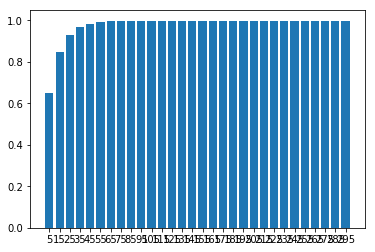

In [38]:
r2_monitor = {5: 0.65211029545805,
 15: 0.8485914561949865,
 25: 0.9279978098685675,
 35: 0.9660291208158869,
 45: 0.9837918571090516,
 55: 0.9921787093615754,
 65: 0.9956939527609688,
 75: 0.9972704933104122,
 85: 0.9979933721328282,
 95: 0.9983273234909336,
 105: 0.998466898753369,
 115: 0.9985605515810347,
 125: 0.9986022859468177,
 135: 0.9986298243818326,
 145: 0.9986534482370703,
 155: 0.9986563419973016,
 165: 0.9986767559326981,
 175: 0.9986810022783341,
 185: 0.9986845863387889,
 195: 0.9986858401557792,
 205: 0.998688767962585,
 215: 0.99869217512235,
 225: 0.9986855046310568,
 235: 0.998690069801307,
 245: 0.9986941010961531,
 255: 0.9986967885341859,
 265: 0.9986894037295959,
 275: 0.9986924854203024,
 285: 0.9986944272764333,
 295: 0.9986940218318288}

names = list(r2_monitor.keys())
values = list(r2_monitor.values())

plt.bar(range(len(r2_monitor)),values,tick_label=names)
plt.show()

## Prediction
***

In [39]:
# Final model
model_final = ALS.train(rating_prep,
                  rank=45,
                  iterations=15,
                  lambda_=0.005,
                  seed=seed
                 )

In [40]:
# Get top N predictions for a user

N = 10
userId = 1

model_1.recommendProducts(userId, N)

[Rating(user=1, product=3836, rating=4.362124052460197),
 Rating(user=1, product=1232, rating=4.254754022773406),
 Rating(user=1, product=2457, rating=4.221554199004412),
 Rating(user=1, product=1916, rating=4.128490400961274),
 Rating(user=1, product=5666, rating=4.040240770323422),
 Rating(user=1, product=2401, rating=3.980743680539773),
 Rating(user=1, product=2467, rating=3.945048781469756),
 Rating(user=1, product=1735, rating=3.941685809607887),
 Rating(user=1, product=2261, rating=3.9227348647783424),
 Rating(user=1, product=43679, rating=3.9192086106109665)]

In [ ]:
# Generate top 10 movie recommendations for each user
userRecs10 = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs10 = model.recommendForAllItems(10)

## References
- Data: https://grouplens.org/datasets/movielens/latest/
- https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/
- https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
- https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
- https://jessesw.com/Rec-System/
- https://www.blabladata.com/2014/12/20/simple-multimodal-design-recommender/
- http://fastml.com/evaluating-recommender-systems/
- http://yifanhu.net/PUB/cf.pdf
-